# Capstone Project - The Best District in Berlin (Week 2)


 ## Note: Please open the notebook in https://nbviewer.jupyter.org for all Figures to be visible.
 
 

## 1. Introduction

 A client has approached our data science team and has requested us to do an analysis of the best district to move in Berlin as she plans to relocate herself into the city. She has the following criteria with respect to the new apartment location:
 
 * The district should have good amount of venues as she likes to go to restaurants and bars during her freetime
 * The crime rate in the area should be relatively low
 
Consequently, what the client is looking for is a district where the ratio of venues/crimes is as high as possible, venues here referring to both restaurants and bars. The exact location or price of the apartment is not relevant to the client and therefor the analysis can be carried out directly on District-to-district comparison.

In order to exceute the work, the following data are needed:

 * A geosjon layer containg the districts of Berlin
 * Statistics on the crime rates in each district
 * Foursquare data on the venues (Restaurants and bars) in each districts
 
 
 


## 2. Methodology

Once the data is available and prepared, we can start assigning venue data and crime rates for each district and then cluster the districts base on these. For the approach, we have chosen first to look at the simple descriptive statistics of the venue number/crime rate -ratio and then by using K-means clustering, cluster the districts based on the available dataset and make a recommendation of the best district for the client.


## 3. The dataset

In [145]:
import geopandas
import pandas as pd
import folium
import requests 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

By searching through the internet, we were able to find the following datasets from Berlin:

In [2]:
#The districts of Berlin as a geosjon-file:

Berlin_boroughs = geopandas.read_file("https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson")
Berlin_boroughs.head()

,name,description,cartodb_id,created_at,updated_at,geometry
0,Mitte,,1,2013-09-03T12:32:04,2013-09-03T12:32:04,"MULTIPOLYGON (((13.40353 52.54021, 13.40419 52..."
1,Friedrichshain-Kreuzberg,,2,2013-09-03T12:32:04,2013-09-03T12:32:04,"MULTIPOLYGON (((13.42940 52.50857, 13.42924 52..."
2,Pankow,,3,2013-09-03T12:32:04,2013-09-03T12:32:04,"MULTIPOLYGON (((13.38928 52.56824, 13.38777 52..."
3,Charlottenburg-Wilmersdorf,,4,2013-09-03T12:32:04,2013-09-03T12:32:04,"MULTIPOLYGON (((13.31279 52.53231, 13.31292 52..."
4,Spandau,,5,2013-09-03T12:32:04,2013-09-03T12:32:04,"MULTIPOLYGON (((13.15028 52.56771, 13.15031 52..."


The names in the geojson-file contains the district names and there are a total of 12 unique districts as shown by the unique name values:

In [3]:
print("Names of Districts:")
Berlin_boroughs.name.value_counts()

Names of Districts:


Neukölln                      1
Mitte                         1
Lichtenberg                   1
Tempelhof-Schöneberg          1
Friedrichshain-Kreuzberg      1
Steglitz-Zehlendorf           1
Treptow-Köpenick              1
Marzahn-Hellersdorf           1
Reinickendorf                 1
Charlottenburg-Wilmersdorf    1
Spandau                       1
Pankow                        1
Name: name, dtype: int64

In [52]:
#The crime data of the districts of Berlin as a csv.file:

crimes = pd.read_csv("datasets_617853_1105847_Berlin_crimes.csv")
crimes.head()

,Year,District,Code,Location,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,2012,Mitte,10111,Tiergarten Süd,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032
1,2012,Mitte,10112,Regierungsviertel,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870
2,2012,Mitte,10113,Alexanderplatz,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108
3,2012,Mitte,10114,Brunnenstraße Süd,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752
4,2012,Mitte,10221,Moabit West,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403


As can be seen, the crimes-database contains the year of the crime, District, Location and the type of the crime. We are mostly interested in the number of total crimes in each district and therefore we can make a summary table of the crimes. We will look at the most recent statistics, so let's see what years are included in the data:

In [5]:
crimes.Year.unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

The years span from 2012 to 2019 and we will take a look mostly at 2019 data. We will do the filtering in the next step of the assignemnt (week 2).

We can also take a first look at the districts on a map:

In [6]:
# Berlin latitude and longitude values
latitude = 52.5200
longitude = 13.4050


In [216]:
# create map and display it
Berlin_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate a map with Berlin's districts

folium.GeoJson(
    Berlin_boroughs,
    name='geojson'
).add_to(Berlin_map)

# display map
Berlin_map

We will also employ Foursquare data, so we will need venue data for each district:

In [8]:
# Foursquare credentials:

CLIENT_ID = 'TX3MNH1WUOEZN2UWS514NOGMA1J4JMEJGQAGJGOZUQHJYYA1' # your Foursquare ID
CLIENT_SECRET = 'B11FZ4UQLH4YACD1KZOX33DOUWQUEOXANSC3AME5TKGHUARJ' # your Foursquare Secret
VERSION = '20200809' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TX3MNH1WUOEZN2UWS514NOGMA1J4JMEJGQAGJGOZUQHJYYA1
CLIENT_SECRET:B11FZ4UQLH4YACD1KZOX33DOUWQUEOXANSC3AME5TKGHUARJ


For querying Foursquare, we need the coordinates of the districts:

In [9]:
#The coordinates of the districts of Berlin as a csv.file:

Berlin_coords = pd.read_csv("Berlin_districts_coordinates.csv")
Berlin_coords

,Lon,Lat,District
0,13.611210,52.429584,Treptow-Köpenick
1,13.239080,52.434845,Steglitz-Zehlendorf
2,13.454966,52.441078,Neukölln
3,13.380766,52.441180,Tempelhof-Schöneberg
4,13.270230,52.501040,Charlottenburg-Wilmersdorf
5,13.428332,52.503883,Friedrichshain-Kreuzberg
6,13.578832,52.521120,Marzahn-Hellersdorf
7,13.178821,52.525798,Spandau
8,13.365964,52.532894,Mitte
9,13.509767,52.534913,Lichtenberg


In [217]:
#Code to get the venues for each neighborhood


def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [218]:
#Here we use a constant search radius for the venues as thsi is considered of sufficient accuracy for the analysis

LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius



Berlin_venues = getNearbyVenues(names=Berlin_coords['District'],
                                   latitudes=Berlin_coords['Lat'],
                                   longitudes=Berlin_coords['Lon']
                                  )

Treptow-Köpenick
Steglitz-Zehlendorf
Neukölln
Tempelhof-Schöneberg
Charlottenburg-Wilmersdorf
Friedrichshain-Kreuzberg
Marzahn-Hellersdorf
Spandau
Mitte
Lichtenberg
Reinickendorf
Pankow


In [12]:
print(Berlin_venues.shape)
Berlin_venues.head()

(1173, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Treptow-Köpenick,52.429584,13.61121,SpreeArche,52.443846,13.618813,Seafood Restaurant
1,Treptow-Köpenick,52.429584,13.61121,Da Dalt,52.453217,13.624990,Ice Cream Shop
2,Treptow-Köpenick,52.429584,13.61121,Mauna Kea,52.452572,13.624984,Café
3,Treptow-Köpenick,52.429584,13.61121,Der GRIECHE,52.446453,13.627280,Greek Restaurant
4,Treptow-Köpenick,52.429584,13.61121,Pizza Dorado,52.424761,13.574858,Pizza Place


Let's plot the venues on map:

In [219]:
# add markers to map

for lat, lon, neighborhood in zip(Berlin_venues['Venue Latitude'], Berlin_venues['Venue Longitude'], Berlin_venues['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Berlin_map)  

#Plot the map
Berlin_map

# Capstone Project - The Best District in Berlin (Week 2)

As our customer is interested mostly on the restaurants and bars of the Districts, in the following we extract the the venues from the Berlin_venue-dataset which contain the words "Restaurant" or "Bar" in the Venue Category:

In [19]:
Berlin_venues = Berlin_venues[Berlin_venues["Venue Category"].str.contains('Restaurant|Bar', na=False)]
Berlin_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Treptow-Köpenick,52.429584,13.61121,SpreeArche,52.443846,13.618813,Seafood Restaurant
3,Treptow-Köpenick,52.429584,13.61121,Der GRIECHE,52.446453,13.627280,Greek Restaurant
6,Treptow-Köpenick,52.429584,13.61121,Gestrandet am Müggelsee,52.444131,13.627124,Beach Bar
12,Treptow-Köpenick,52.429584,13.61121,Kikko Grill & Sushi,52.444643,13.574246,Sushi Restaurant
13,Treptow-Köpenick,52.429584,13.61121,Duke Bar,52.447673,13.576494,Cocktail Bar


In [21]:
# Check for the unique Venue Category values so that there are nonly restaurants and bars:

Berlin_venues["Venue Category"].unique()

array(['Seafood Restaurant', 'Greek Restaurant', 'Beach Bar',
       'Sushi Restaurant', 'Cocktail Bar', 'Indian Restaurant', 'Bar',
       'German Restaurant', 'Italian Restaurant', 'American Restaurant',
       'Asian Restaurant', 'Middle Eastern Restaurant', 'Thai Restaurant',
       'Doner Restaurant', 'Swiss Restaurant', 'Caucasian Restaurant',
       'Restaurant', 'Vegetarian / Vegan Restaurant',
       'Turkish Restaurant', 'Vietnamese Restaurant',
       'Fast Food Restaurant', 'Eastern European Restaurant',
       'African Restaurant', 'Beer Bar',
       'Turkish Home Cooking Restaurant', 'Whisky Bar',
       'Falafel Restaurant', 'Spanish Restaurant', 'Chinese Restaurant',
       'Korean Restaurant', 'French Restaurant',
       'Mediterranean Restaurant', 'Persian Restaurant',
       'Portuguese Restaurant', 'Modern European Restaurant',
       'Japanese Restaurant', 'Kebab Restaurant', 'Wine Bar',
       'Lebanese Restaurant', 'Hotel Bar', 'Dumpling Restaurant',
       'Mexi

Next we'll want to have a dataframe that has the number of restaurants and bars witin each district:

In [61]:
Berlin_count = Berlin_venues.Neighborhood.value_counts().to_frame()
Berlin_count.reset_index(inplace=True)
Berlin_count.rename(columns={"index": "District", "Neighborhood": "venue_count"}, inplace=True)
Berlin_count

,District,venue_count
0,Neukölln,37
1,Charlottenburg-Wilmersdorf,34
2,Friedrichshain-Kreuzberg,33
3,Reinickendorf,32
4,Lichtenberg,30
5,Tempelhof-Schöneberg,29
6,Steglitz-Zehlendorf,25
7,Treptow-Köpenick,24
8,Spandau,22
9,Mitte,17


As we want to include the crime data as well, we need to modify the Crime-database so that it contains sum of crimes in each district and append this to the Venue count dataframe shown above. The crimes-dataframe contains several columns for different types of crimes, so we'll first need to sum up the different crime-columns for each district for each year:

In [53]:
# First we drop the unnecessary "Code" and "Location" columns:

crimes.drop(['Code', 'Location'], axis=1, inplace=True)
crimes.head()


,Year,District,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local
0,2012,Mitte,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032
1,2012,Mitte,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870
2,2012,Mitte,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108
3,2012,Mitte,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752
4,2012,Mitte,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403


In [54]:
columns_to_sum = crimes.columns.tolist()
columns_to_sum.remove("Year")
columns_to_sum.remove("District")

crimes["crime_count"] = crimes[columns_to_sum].sum(axis=1)
crimes.head()

,Year,District,Robbery,Street_robbery,Injury,Agg_assault,Threat,Theft,Car,From_car,Bike,Burglary,Fire,Arson,Damage,Graffiti,Drugs,Local,crime_count
0,2012,Mitte,70,46,586,194,118,2263,18,328,120,68,16,4,273,26,171,1032,5333
1,2012,Mitte,65,29,474,123,142,3203,10,307,170,37,10,4,380,124,98,870,6046
2,2012,Mitte,242,136,1541,454,304,8988,81,792,822,275,49,27,1538,522,435,3108,19314
3,2012,Mitte,52,25,254,60,66,1916,86,192,396,131,14,5,428,122,213,752,4712
4,2012,Mitte,130,51,629,185,199,2470,94,410,325,161,42,22,516,64,259,1403,6960


In [55]:
#Drop the irrelevant columns:

crimes.drop(columns_to_sum, axis=1, inplace=True)
crimes.head()

,Year,District,crime_count
0,2012,Mitte,5333
1,2012,Mitte,6046
2,2012,Mitte,19314
3,2012,Mitte,4712
4,2012,Mitte,6960


In [59]:
# Now we need to sum up counts for each year:

crimes_count = crimes.groupby(['Year', 'District'])['crime_count'].sum().reset_index()
crimes_count

,Year,District,crime_count
0,2012,Charlottenburg-Wilmersdorf,57053
1,2012,Friedrichshain-Kreuzberg,57969
2,2012,Lichtenberg,31794
3,2012,Marzahn-Hellersdorf,29624
4,2012,Mitte,88278
...,...,...,...
91,2019,Reinickendorf,27846
92,2019,Spandau,26872
93,2019,Steglitz-Zehlendorf,29080
94,2019,Tempelhof-Schöneberg,44895


Now let's append this with the Berlin_count dataframe, using district as the key:

In [63]:
Berlin = pd.merge(crimes_count, Berlin_count, on='District', how='inner')
Berlin

,Year,District,crime_count,venue_count
0,2012,Charlottenburg-Wilmersdorf,57053,34
1,2013,Charlottenburg-Wilmersdorf,59329,34
2,2014,Charlottenburg-Wilmersdorf,59990,34
3,2015,Charlottenburg-Wilmersdorf,63567,34
4,2016,Charlottenburg-Wilmersdorf,60363,34
...,...,...,...,...
91,2015,Treptow-Köpenick,28395,24
92,2016,Treptow-Köpenick,30469,24
93,2017,Treptow-Köpenick,30006,24
94,2018,Treptow-Köpenick,29597,24


As a final column we want to add a column whit the ratio of venues counts versus crirme count as we want to have a parameter, which uses both values for assessing the "quality" of each district. The higher the venue_count-value, the larger the parameter and the larger the crime_count, the smaller the parameter. I.e. high value of the ratio indicates that the district is relatively suitable for our client. So let's add the ratio and normalize the value to be between 0 and 1 by dividing with the largest suitability index value:

In [67]:
Berlin["suitability_index"] = Berlin["venue_count"]/Berlin["crime_count"]
Berlin["suitability_index"] = Berlin["suitability_index"]/max(Berlin["suitability_index"])
Berlin

,Year,District,crime_count,venue_count,suitability_index
0,2012,Charlottenburg-Wilmersdorf,57053,34,0.518577
1,2013,Charlottenburg-Wilmersdorf,59329,34,0.498683
2,2014,Charlottenburg-Wilmersdorf,59990,34,0.493188
3,2015,Charlottenburg-Wilmersdorf,63567,34,0.465436
4,2016,Charlottenburg-Wilmersdorf,60363,34,0.490141
...,...,...,...,...,...
91,2015,Treptow-Köpenick,28395,24,0.735499
92,2016,Treptow-Köpenick,30469,24,0.685434
93,2017,Treptow-Köpenick,30006,24,0.696011
94,2018,Treptow-Köpenick,29597,24,0.705629


Now the dataset is ready for exploratory visualization and further analysis


## 4. Results

Let's take a look first at the suitability index of each district by year by plotting the suitability index per year, group according to the district:


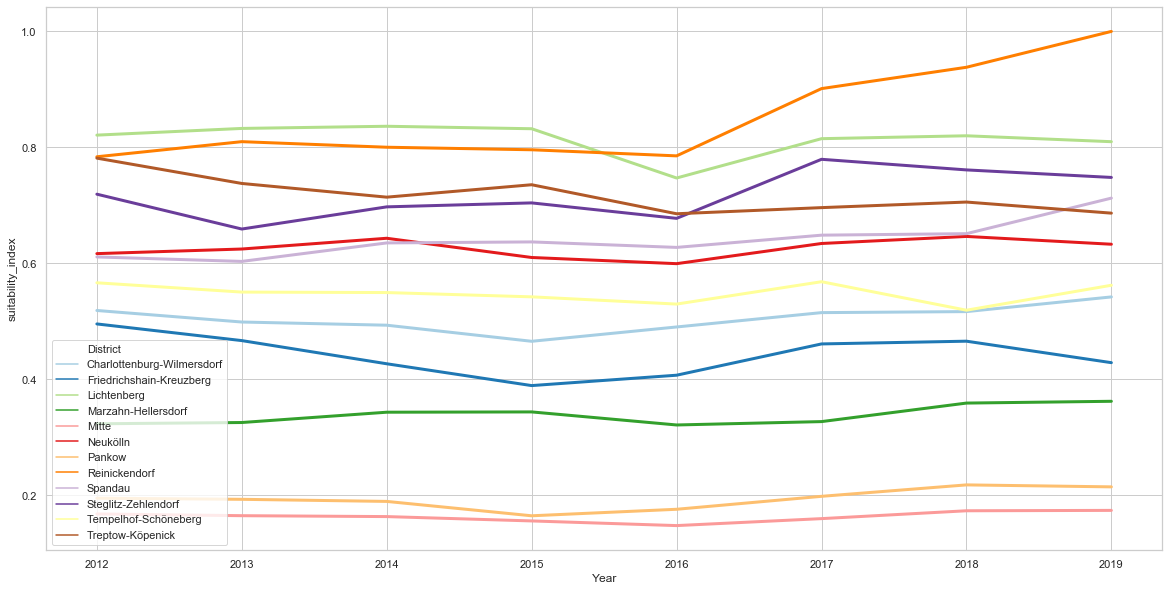

In [93]:
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))
plt.figure(figsize=(20,10))
sns.lineplot(x="Year", y="suitability_index", hue="District",data=Berlin, lw=3)


The plot above gives already much insight onto the venue_count/crime_count ratio for each district. It is evident that the Renickendorf-district has the highest suitability index and the Mitte the lowest. In addition, the index-values seem to have been rather constant for each of the districts, thus there is no need to assess the changes of the index-values any furter and we can focus only on the year 2019 in the following. So let's make a bar blot of the values for each district for the year 2019:

In [194]:
Berlin2019 = Berlin[Berlin["Year"]==2019]
Berlin2019 = Berlin2019.sort_values("suitability_index", ascending=False)
Berlin2019.head()

,Year,District,crime_count,venue_count,suitability_index
63,2019,Reinickendorf,27846,32,1.000000
23,2019,Lichtenberg,32239,30,0.809753
79,2019,Steglitz-Zehlendorf,29080,25,0.748098
71,2019,Spandau,26872,22,0.712419
95,2019,Treptow-Köpenick,30422,24,0.686493


[Text(0, 0, 'Reinickendorf'),
 Text(0, 0, 'Lichtenberg'),
 Text(0, 0, 'Steglitz-Zehlendorf'),
 Text(0, 0, 'Spandau'),
 Text(0, 0, 'Treptow-Köpenick'),
 Text(0, 0, 'Neukölln'),
 Text(0, 0, 'Tempelhof-Schöneberg'),
 Text(0, 0, 'Charlottenburg-Wilmersdorf'),
 Text(0, 0, 'Friedrichshain-Kreuzberg'),
 Text(0, 0, 'Marzahn-Hellersdorf'),
 Text(0, 0, 'Pankow'),
 Text(0, 0, 'Mitte')]

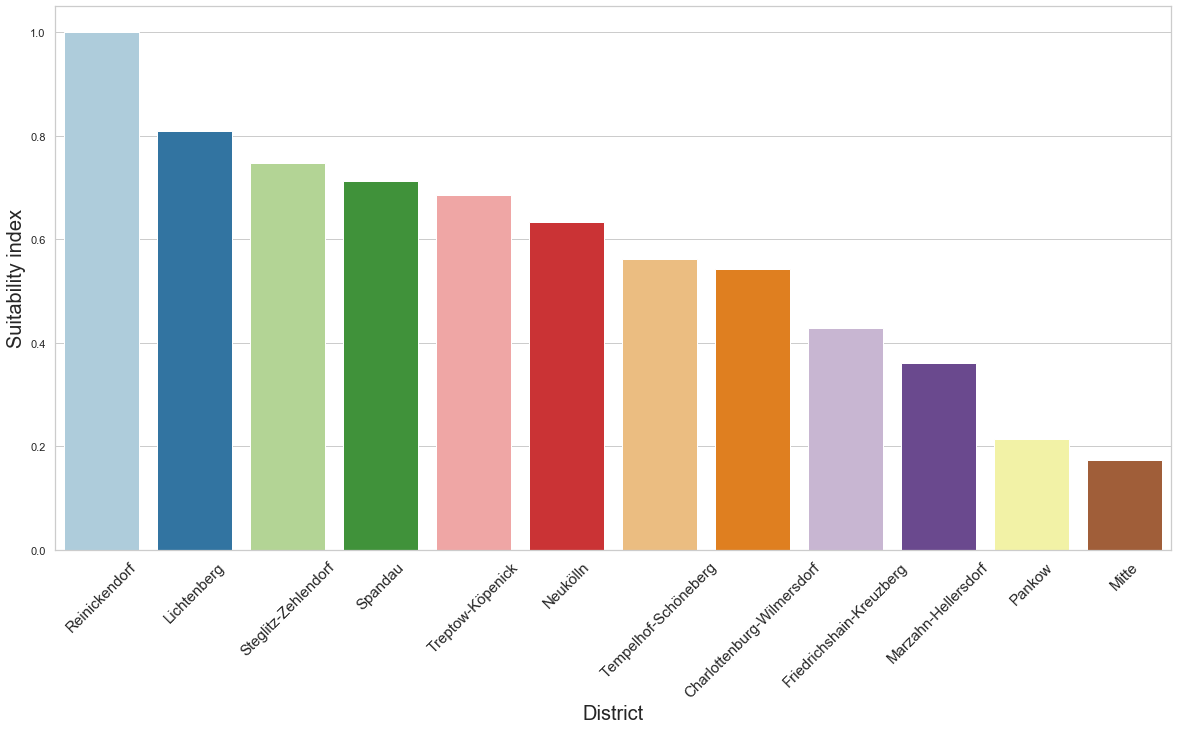

In [114]:
plt.figure(figsize=(20,10))
b = sns.barplot(x="District", y="suitability_index", data=Berlin2019)
b.set_xlabel("District",fontsize=20)
b.set_ylabel("Suitability index",fontsize=20)
b.set_xticklabels(b.get_xticklabels(), rotation=45,fontsize=15)

Here we see the same effect for the year 2019 as already shown in the lineplot above - Renickendorf-district has clerly the highest suitability index and the Mitte the lowest. Thus we could already recommend Renickendorf as the best district for our client based on the venue/crimes-ratio. But let's also explore if we can cluster the district to clear groups as well using k-means clustering. But before that, let's plot a choropleth map using the suitability indexes as the color-sources:

In [206]:
# create map and display it
Berlin_map2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate a map with Berlin's districts



folium.Choropleth(
    geo_data=Berlin_boroughs,
    name='choropleth',
    data=Berlin2019,
    columns=['District', 'suitability_index'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='suitability index'
).add_to(Berlin_map2)

Berlin_map2

As can be seen from the map, Renickendorf-district, which has the highest suitability index, is located in the nortwestern part of Berlin. The lowest suitability indexes close to the city centre or northern parts of the city.

Next we can run K-means clustering on the dataset, just to see the similarities between the districts. As is does not make sense to do the clustering with a single variable, we'll use the venue and crime counts for the clustering. So let's run the K-means clustering. let's try 4 clusters at start

In [195]:
# set number of clusters
kclusters = 4

Berlin2019_grouped_clustering = Berlin2019.drop(['Year','District','suitability_index'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Berlin2019_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:12] 

array([1, 1, 1, 1, 1, 2, 2, 2, 3, 1, 2, 0])

In [196]:
# Add the cluster labels to the original dataset:

Berlin2019.insert(0, 'Cluster Labels', kmeans.labels_)
Berlin2019

,Cluster Labels,Year,District,crime_count,venue_count,suitability_index
63,1,2019,Reinickendorf,27846,32,1.000000
23,1,2019,Lichtenberg,32239,30,0.809753
79,1,2019,Steglitz-Zehlendorf,29080,25,0.748098
71,1,2019,Spandau,26872,22,0.712419
95,1,2019,Treptow-Köpenick,30422,24,0.686493
47,2,2019,Neukölln,50875,37,0.632864
87,2,2019,Tempelhof-Schöneberg,44895,29,0.562099
7,2,2019,Charlottenburg-Wilmersdorf,54589,34,0.541984
15,3,2019,Friedrichshain-Kreuzberg,67008,33,0.428549
31,1,2019,Marzahn-Hellersdorf,26447,11,0.361934


Text(0, 0.5, 'Venue count')

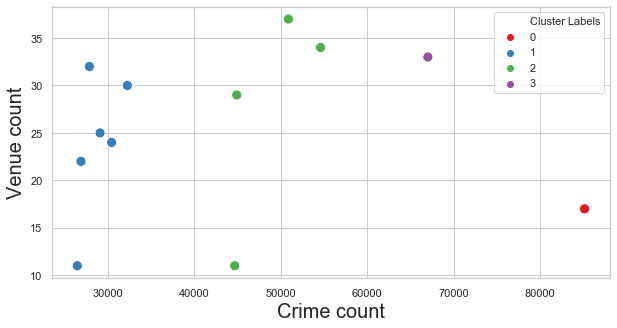

In [200]:
#Lets plot the data and see whether the three clusters make sense:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
b = sns.scatterplot(x="crime_count", y="venue_count",hue="Cluster Labels", s=100,data=Berlin2019,palette="Set1")
b.set_xlabel("Crime count",fontsize=20)
b.set_ylabel("Venue count",fontsize=20)


Teh clustering seems rather reasonable and it does not make much sense to drive for more groups. Based on the figure, the follwing clusters can be identified:

    0. Low venue count and hight crime count
    1. Modest to high venue count and low crime count
    2. Modest to high venue count and modest crime count
    3. High venue count and modest crime count
    
In order to make the clusters more clear, let's plot the clusters againts suitability index:    


Text(0, 0.5, 'Suitability index')

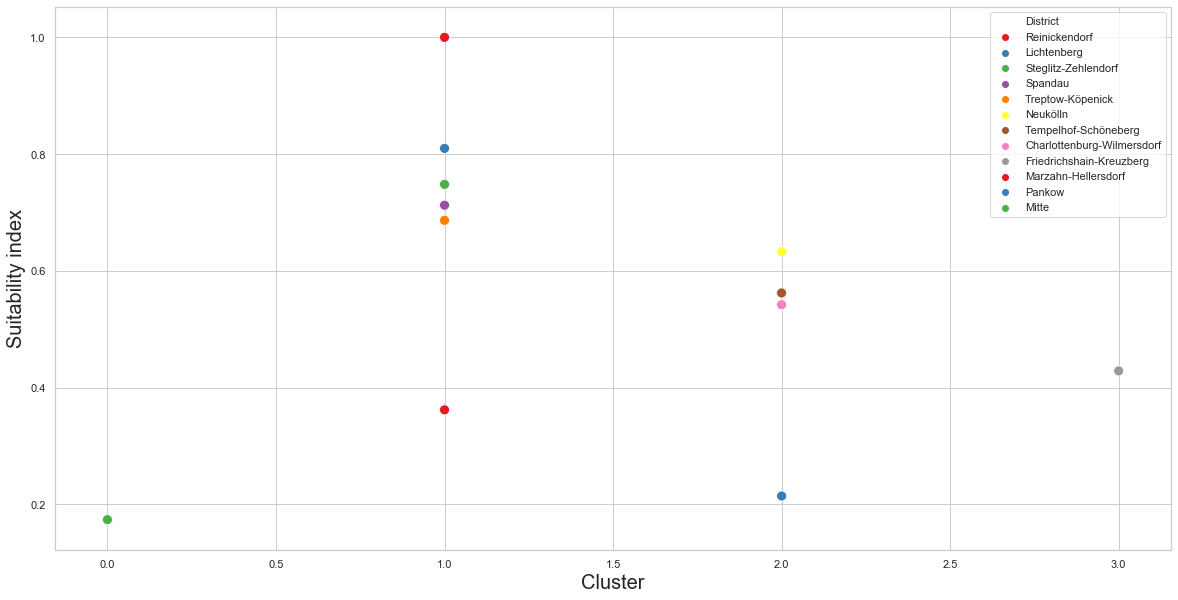

In [210]:
#Lets plot the data and see whether the three clusters make sense:

sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
b = sns.scatterplot(x="Cluster Labels", y="suitability_index",hue="District", s=100,data=Berlin2019,palette="Set1")
b.set_xlabel("Cluster",fontsize=20)
b.set_ylabel("Suitability index",fontsize=20)


Let's plot the clusters on the map as well:   

In [208]:
# create map and display it
Berlin_map3 = folium.Map(location=[latitude, longitude], zoom_start=10)

# generate a map with Berlin's districts



folium.Choropleth(
    geo_data=Berlin_boroughs,
    name='choropleth',
    data=Berlin2019,
    columns=['District', 'Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cluster'
).add_to(Berlin_map3)

Berlin_map3

## 5. Discussion

Based on the analysis above, the suitability index, which is a measure of the count of restaurants and bars in a district divided by the number of crimes in the district gives an index value which can be used to asses, which are the best districts for the client to relocate herself within Berlin. Based on the analysis, the highest suitability index is for the Renickendorf-district and the lowest for the Mitte. Using a K-means clustering, we could also classify the districts into four different classes, which share similar venue and crime counts and could therefore considered as potential district as well. Renickendorf-district belongs to the cluster 1 and the districts which belong to the same cluster are given in the table below. The cluster includes a total of 6 districts and all of these, yet exlucding Marzahn-Hellersdorf which has anomalously low suitability index, could be considered as potential districts for the client as well. 

It is noted that the analysis is based on crime data from 2019 and as such contains some uncertainties on what the current status with respect to crime counts is. But it is expected that these are similar in the present day as the crime count trends were rather constant. The venue count is also dependent on what venues are registered into the Foursquare database, yielding further uncertainty on the results, but the Foursquare data is considered as the best available at this time and the results therefore indicative of the true situation in Berlin. 


In [215]:
Berlin2019[Berlin2019["Cluster Labels"]==1]

,Cluster Labels,Year,District,crime_count,venue_count,suitability_index
63,1,2019,Reinickendorf,27846,32,1.000000
23,1,2019,Lichtenberg,32239,30,0.809753
79,1,2019,Steglitz-Zehlendorf,29080,25,0.748098
71,1,2019,Spandau,26872,22,0.712419
95,1,2019,Treptow-Köpenick,30422,24,0.686493
31,1,2019,Marzahn-Hellersdorf,26447,11,0.361934


## 6. Conclusions

Based on the analysis and on the numbers of reported crimes and restaurants and bars in Berlin, we recommend that the client should look for apartment in the Renickendorf-district as this has the highest suitability index (ratio of venues to crimes). The Renickendorf-district shares however similar suitability index with the following district, which could also be consider as potential districts for relocation:

    *Lichtenberg
    *Steglitz-Zehlendorf
    *Spandau
    *Treptow-Köpenick